<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 6. Regresión Logística: Implementación sobre el dataset de banking</span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>


# Regresión Logística Aplicada: Predicción de Éxito en Campañas Bancarias

En este notebook vamos a aplicar el modelo de **regresión logística** al clásico dataset de *marketing bancario* publicado por una institución financiera portuguesa. Este conjunto de datos contiene información sobre campañas de telemarketing, con variables socioeconómicas y datos de contacto de los clientes, con el objetivo de predecir si el cliente **aceptará o no** una oferta de suscripción a un depósito a plazo fijo (`y = yes / no`).

> Este caso es ideal para estudiar clasificación binaria en un contexto real, con variables categóricas, desbalanceo de clases y múltiples factores sociales y económicos que afectan la decisión del cliente.

A lo largo del notebook, realizaremos:

1. Análisis exploratorio y limpieza de datos.
2. Codificación de variables categóricas.
3. Entrenamiento de un modelo de regresión logística con `scikit-learn`.
4. Evaluación del modelo con métricas adecuadas (matriz de confusión, F1-score, AUC).
5. Interpretación de coeficientes del modelo.

Nuestro objetivo es construir un modelo **interpretable y útil para la toma de decisiones**, no solo evaluar su precisión, sino también entender **qué variables influyen más en la respuesta del cliente**.

In [1]:
# Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score


In [2]:
mainpath = "../data/"
filename = "banking/bank.csv"
fullpath = os.path.join(mainpath,filename)

df_bank = pd.read_csv(fullpath, sep=';') # la separación de este csv es ;
#df_bank = pd.read_csv(fullpath)
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

Aunque no se encuentre marcado como null, si existen valores nulos en este dataset, pero en categorías como "unknown", etc.

In [4]:
# Tenemos 4119 registros y 21 variables
df_bank.shape

(4119, 21)

In [5]:
# un vistazo al nombre de las columnas
df_bank.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'], dtype=object)

La columna $y$ es la variable a predecir, si el cliente compró un producto o no. Checamos como se encuentra distribuida esta variable.

In [6]:
df_bank['y'].value_counts()

y
no     3668
yes     451
Name: count, dtype: int64

### Observaciones iniciales

- El dataset contiene aproximadamente 4119 filas y 21 columnas.
- La variable objetivo `y` es binaria: `yes` o `no`, indicando si el cliente aceptó el producto.
- Hay muchas variables categóricas que requerirán codificación para poder usarse en un modelo.
- Parece haber un **desbalance** en la variable objetivo: la mayoría de los clientes **no** aceptan la oferta. Esto debe tenerse en cuenta al evaluar el modelo.

## Preprocesamiento de datos

Antes de entrenar el modelo, es necesario preparar el conjunto de datos. Este dataset contiene muchas **variables categóricas**, que deben ser transformadas en variables numéricas para que puedan ser utilizadas por el modelo de regresión logística.

También es importante:
- Verificar valores faltantes.
- Convertir la variable objetivo (`y`) a formato binario (`1` = sí, `0` = no).
- Estandarizar algunas variables numéricas si es necesario (aunque en regresión logística no es obligatorio para el modelo, ayuda a interpretar y visualizar coeficientes).

Podemos empezar con algo simple, la codificación de la variable objetivo `y`.

In [7]:
df_bank['y'] = df_bank['y'].map({'yes': 1, 'no': 0})
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


A continuación. Notamos que la variable `education` tiene algunas etiquetas que podemos juntar dentro de una misma categoría. La categoría de la educación podría ser importante para ver si compras o no un producto de inversión.

In [8]:
df_bank['education'].unique()
# la educacion basica se encuentra por años

array(['basic.9y', 'high.school', 'university.degree',
       'professional.course', 'basic.6y', 'basic.4y', 'unknown',
       'illiterate'], dtype=object)

In [9]:
# tenemos mucha informacion (sobre todo de educacion basica), está muy segmentado
## podemos agrupar esta educación básica y hacerlo una sola categoría

df_bank['education'] = np.where(df_bank['education'] == "basic.4y", "Basic", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "basic.6y", "Basic", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "basic.9y", "Basic", df_bank["education"])

## checar que la variable sea educacion basica y renombrarla como "Basic"
# en caso contrario quedarse con la información de df_bank["education"] sin modificar

# para las demas

df_bank['education'] = np.where(df_bank['education'] == "high.school", "High School", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "professional.course", "Professional Course", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "university.degree", "University Degree", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "illiterate", "Illiterate", df_bank["education"])
df_bank['education'] = np.where(df_bank['education'] == "unknown", "Unknown", df_bank["education"])

In [10]:
# Checamos
df_bank['education'].unique()

array(['Basic', 'High School', 'University Degree', 'Professional Course',
       'Unknown', 'Illiterate'], dtype=object)

Ya hicimos como una especie de 'cleaning' de los datos. Ahora lo que podemos hacer es un análisis exploratorio de los datos.

## Análisis exploratorio

Aquí nos fijamos en cuales variables son más significativas.

In [11]:
# Podemos hacer una separación entre variables categoricas y numericas del dataset
cat_cols = df_bank.select_dtypes(include='object').columns
num_cols = df_bank.select_dtypes(include='number').columns

In [12]:
# Podemos hacer un agrupamiento de las variables numéricas
df_bank[num_cols].groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
0,39.895311,219.40976,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072
1,41.889135,560.78714,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625


* La variable `pdays`, dias desde que el cliente fue contactado por ultima vez, es considerablemente menor en el caso del cliente que si compran, cuanto menor sea el número de días el cliente tiene mejor memoria y hay más probabilidad de comprar el producto.
* De manera extraña, se observa que la variable `campaign`, numero de veces que se ha contactado a un cliente durante la campaña actual, cuanta menos veces los contactas mayor probabilidad hay de que compre.

In [13]:
# Para variables categóricas podemos hacer tablas de contingencia

for col in cat_cols:
    display(pd.crosstab(df_bank[col], df_bank['y'], normalize='index')\
              .style.format("{:.1%}").set_caption(f"Distribución de 'y' según {col}"))

y,0,1
job,,
admin.,86.9%,13.1%
blue-collar,93.1%,6.9%
entrepreneur,94.6%,5.4%
housemaid,90.0%,10.0%
management,90.7%,9.3%
retired,77.1%,22.9%
self-employed,91.8%,8.2%
services,91.1%,8.9%
student,76.8%,23.2%


y,0,1
marital,,
divorced,90.4%,9.6%
married,90.0%,10.0%
single,86.6%,13.4%
unknown,90.9%,9.1%


y,0,1
education,,
Basic,92.0%,8.0%
High School,89.5%,10.5%
Illiterate,100.0%,0.0%
Professional Course,87.9%,12.1%
University Degree,86.9%,13.1%
Unknown,84.4%,15.6%


y,0,1
default,,
no,87.9%,12.1%
unknown,93.9%,6.1%
yes,100.0%,0.0%


y,0,1
housing,,
no,89.0%,11.0%
unknown,91.4%,8.6%
yes,89.0%,11.0%


y,0,1
loan,,
no,88.8%,11.2%
unknown,91.4%,8.6%
yes,89.8%,10.2%


y,0,1
contact,,
cellular,85.9%,14.1%
telephone,94.8%,5.2%


y,0,1
month,,
apr,83.3%,16.7%
aug,89.9%,10.1%
dec,45.5%,54.5%
jul,91.7%,8.3%
jun,87.2%,12.8%
mar,41.7%,58.3%
may,93.5%,6.5%
nov,90.4%,9.6%
oct,63.8%,36.2%


y,0,1
day_of_week,,
fri,89.2%,10.8%
mon,88.5%,11.5%
thu,88.8%,11.2%
tue,89.2%,10.8%
wed,89.6%,10.4%


y,0,1
poutcome,,
failure,85.2%,14.8%
nonexistent,91.7%,8.3%
success,35.2%,64.8%


In [14]:
## para la variable de la categoria de nivel de estudios
df_bank.groupby('education').size().to_frame()

,0
education,
Basic,1231
High School,921
Illiterate,1
Professional Course,535
University Degree,1264
Unknown,167


Solo hay una observacion illiterate.

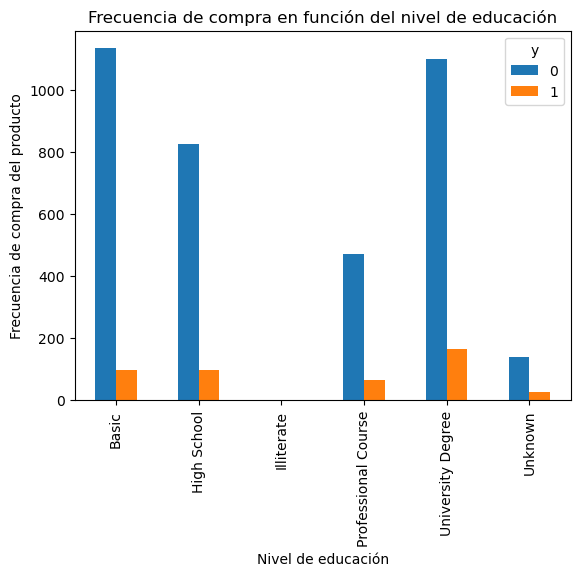

In [15]:
pd.crosstab(df_bank.education, df_bank.y).plot(kind = 'bar')
plt.title ("Frecuencia de compra en función del nivel de educación")
plt.xlabel("Nivel de educación")
plt.ylabel("Frecuencia de compra del producto")
plt.show()

Parece ser que los que más compran el producto tienden a ser los universitarios.

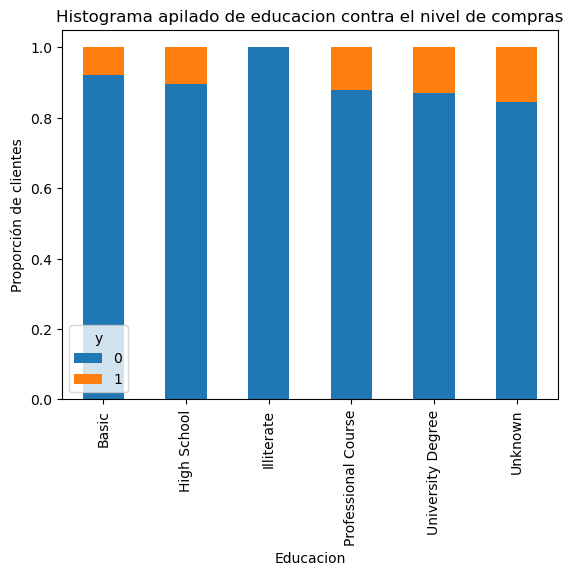

In [16]:
# diagrama de barras apilado
table = pd.crosstab(df_bank.education, df_bank.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True) #division por filas y que lo haga por columnas
# cada columna queda dividido por la suma de las filas
plt.title('Histograma apilado de educacion contra el nivel de compras')
plt.xlabel('Educacion')
plt.ylabel('Proporción de clientes')
plt.show()

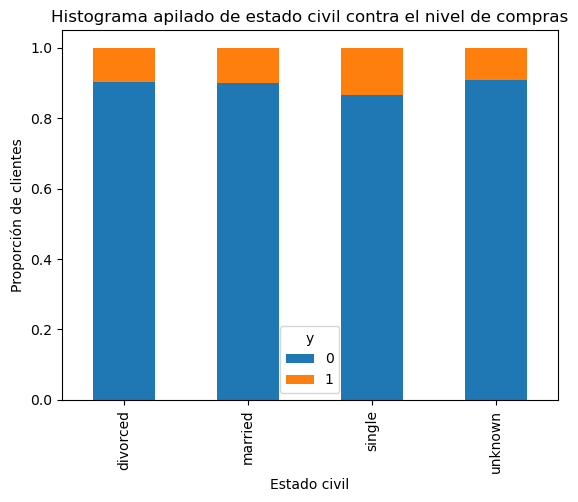

In [17]:
table = pd.crosstab(df_bank.marital, df_bank.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True) #division por filas y que lo haga por columnas
# cada columna queda dividido por la suma de las filas
plt.title('Histograma apilado de estado civil contra el nivel de compras')
plt.xlabel('Estado civil')
plt.ylabel('Proporción de clientes')
plt.show()

Podemos intentar averiguar si hay algún día de la semana que tenga influencia.

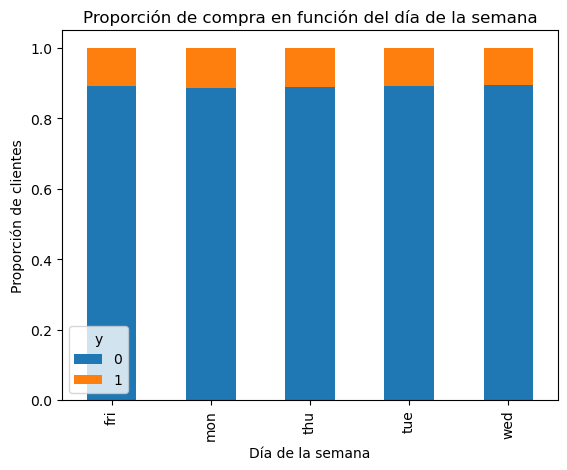

In [18]:
table = pd.crosstab(df_bank.day_of_week, df_bank.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True) #division por filas y que lo haga por columnas
plt.title('Proporción de compra en función del día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Proporción de clientes')
plt.show()

No se ve una tendencia clara

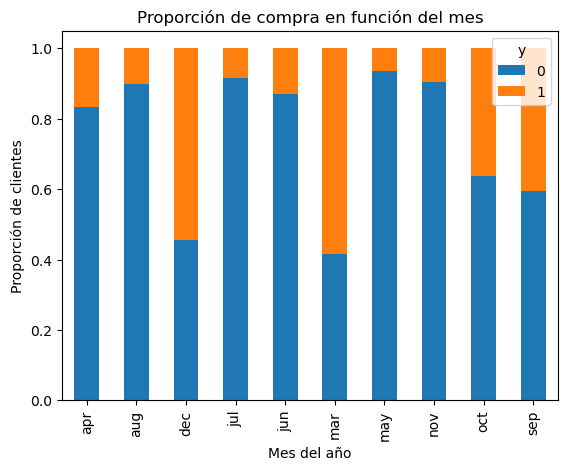

In [19]:
#respecto al mes
table = pd.crosstab(df_bank.month, df_bank.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True) #division por filas y que lo haga por columnas
plt.title('Proporción de compra en función del mes')
plt.xlabel('Mes del año')
plt.ylabel('Proporción de clientes')
plt.show()

Aquí se ve algo importante. Mucha de la gente rechaza en mayo. Tal vez la intuición nos dice que la edad es importante.


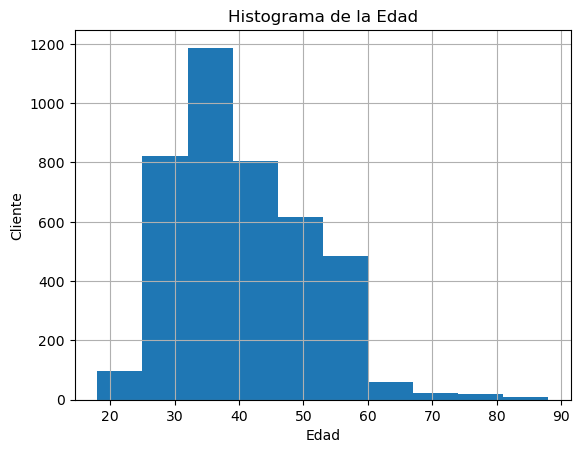

In [20]:
df_bank.age.hist()
plt.title('Histograma de la Edad')
plt.xlabel('Edad')
plt.ylabel('Cliente')
plt.show()

La mayoría de la gente está entre los 30 y 40 años.

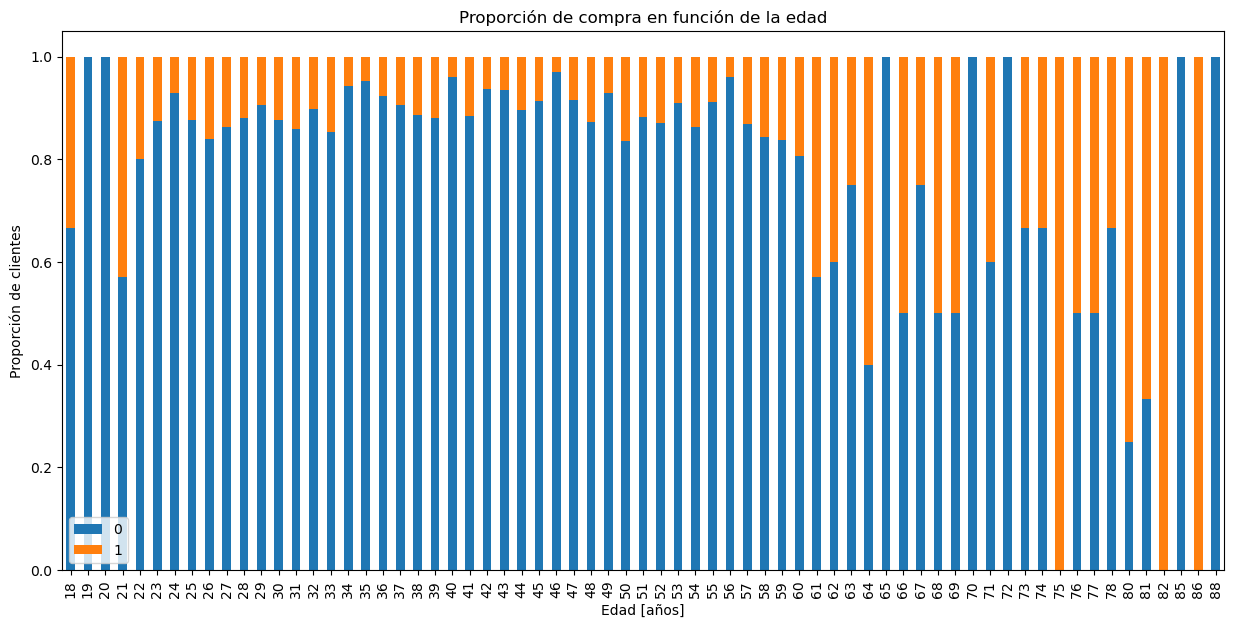

In [21]:
table = pd.crosstab(df_bank.age, df_bank.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize=(15,7)) #division por filas y que lo haga por columnas
plt.title('Proporción de compra en función de la edad')
plt.xlabel('Edad [años]')
plt.ylabel('Proporción de clientes')
plt.legend(loc='lower left')
plt.show()

Parece que aumenta la proporción cerca de los 50 años. Ahora pasamos el número de veces que fue consultado el usuario.


In [22]:
pd.crosstab(df_bank.poutcome, df_bank.y)

y,0,1
poutcome,,
failure,387,67
nonexistent,3231,292
success,50,92


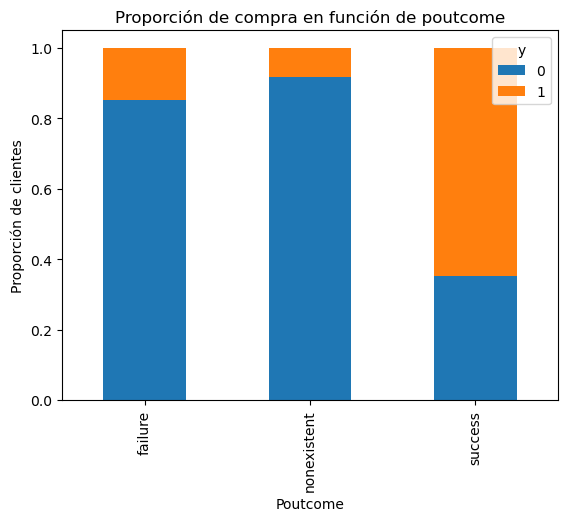

In [23]:
table = pd.crosstab(df_bank.poutcome, df_bank.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True) #division por filas y que lo haga por columnas
plt.title('Proporción de compra en función de poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Proporción de clientes')
plt.show()

Aquí se tiene la experiencia en este tipo de productos. Los que habían fracasado tienen más tendencia a decir que no. Y por el caso extrema, los que tienen éxito es más probable que repitan.

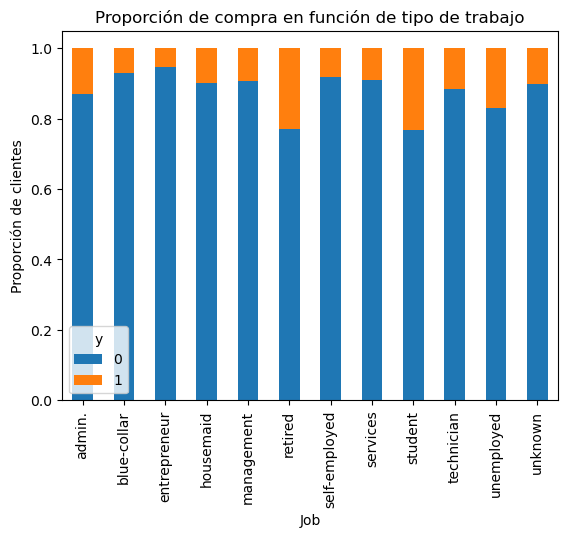

In [24]:
# Tipo de trabajo
table = pd.crosstab(df_bank.job, df_bank.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True) #division por filas y que lo haga por columnas
plt.title('Proporción de compra en función de tipo de trabajo')
plt.xlabel('Job')
plt.ylabel('Proporción de clientes')
plt.show()

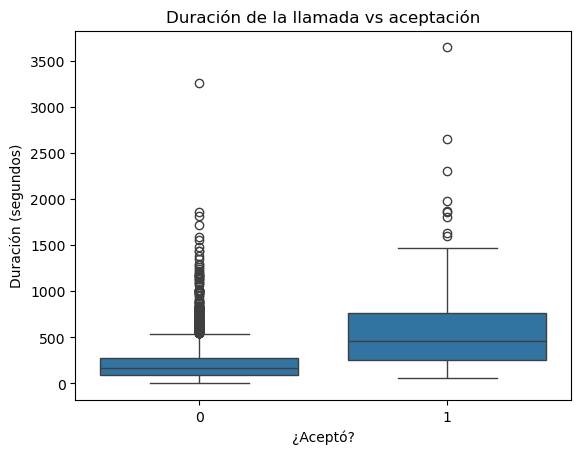

In [25]:
# Duración de la llamada

sns.boxplot(data=df_bank, x='y', y='duration')
plt.title('Duración de la llamada vs aceptación')
plt.xlabel('¿Aceptó?')
plt.ylabel('Duración (segundos)')
plt.show()

Algunas conclusiones:

- El dataset presenta un claro **desbalance de clases**.
- Variables como `duration`, `job`, `education`, `contact` y `month` parecen estar relacionadas con la probabilidad de aceptación.
- La variable `duration` tiene alta correlación con el objetivo, pero puede ser **engañosa** si no se interpreta correctamente.
- Este análisis nos ayuda a tomar decisiones sobre selección de variables y codificación.

> Ahora sí, estamos listos para codificar variables categóricas y construir nuestro modelo.


Hay muchas variables categóricas que podríamos trabajar como variables dummies.

## Codificación de variables categóricas

In [26]:
# Aplicamos codificación one-hot
df_bank_encoded = pd.get_dummies(df_bank, columns=cat_cols, drop_first=True, dtype=int)
df_bank_encoded.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,1,0,0,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,1,0,0,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,0,1,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,0,0,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,1,0,0,1,0,0,0,1,0


In [27]:
df_bank_encoded.columns.values
# salen un monton de columnas dummies

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_High School', 'education_Illiterate',
       'education_Professional Course', 'education_University Degree',
       'education_Unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent',
       'poutcome_success'], dtype=object)

## División del conjunto de datos y entrenamiento del modelo

Una vez que nuestros datos están limpios y codificados, procedemos a:

* Separar las variables predictoras (`X`) y la variable objetivo (`y`).
* Dividir los datos en conjunto de **entrenamiento** y **prueba**, para evaluar el modelo con datos no vistos.
* Entrenar un modelo de **regresión logística** usando `scikit-learn`.

In [28]:
# Matriz de características X y variable objetivo y
X = df_bank_encoded.drop('y', axis=1) # todo menos y
y = df_bank_encoded['y']

### Selección de variables con RFE (Recursive Feature Elimination)

Antes de entrenar el modelo, es útil preguntarnos:  
> ¿Todas las variables realmente aportan información relevante?  
> ¿Podemos eliminar algunas sin perder rendimiento?

El método **RFE (Recursive Feature Elimination)** es una técnica de selección de variables que **elimina recursivamente** las menos importantes según un modelo base (como la regresión logística), hasta quedarse con un subconjunto óptimo.

El proceso funciona así:
1. Entrena un modelo sobre el conjunto completo de variables.
2. Calcula la importancia de cada variable (por ejemplo, mediante coeficientes absolutos).
3. Elimina la variable menos importante.
4. Repite hasta alcanzar el número deseado de variables.

Este método ayuda a:
- Reducir la complejidad del modelo.
- Mejorar la interpretabilidad.
- Evitar el sobreajuste cuando hay muchas variables irrelevantes.

A continuación, aplicaremos RFE con regresión logística como modelo base para seleccionar las variables más relevantes antes de entrenar el modelo final.

In [29]:
# Empecemos con un modelo de 12 variables, por ejemplo
n = 12

# Instanciamos el modelo base
lr = LogisticRegression(max_iter=10000)

# Instanciamos el método RFE para elegir las n variables más importantes
rfe = RFE(lr, n_features_to_select=n, step=2) # el módelo lr instanciado previamente es el que toma de referencia, step se refiere a cuantas variables se quita por iteracion

# Ajustamos el método RFE
rfe = rfe.fit(X, y)

In [30]:
# aqui se ve automáticamente cuales son las que se van a quedar dentro del modelo
print(rfe.support_)

[False False False False  True False False False  True False False  True
 False  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False  True  True  True  True  True False False False False False False
 False  True  True]


In [31]:
# Ranking de variables que se quedaban en el modelo 
print(rfe.ranking_)

[17 20 13 21  1 12 17 13  1 19  2  1 14  1  5  1  3 16 15  8  4 11 11 19
 20  9  8  9  5 16 21  6  7  6 10  3 12  1  1  1  1  1 10 18  4 14 18 15
  7  1  1]


In [32]:
# podemos hacer una tabla para ver cuáles variables quedaron

# Crear un DataFrame con los resultados
rfe_results = pd.DataFrame({
    'Variable': X.columns,
    'Seleccionada': rfe.support_,
    'Ranking': rfe.ranking_
})

# Ordenar por ranking (1 = más importante)
rfe_results = rfe_results.sort_values(by='Ranking')

# Mostrar la tabla
rfe_results.style\
    .applymap(lambda val: 'background-color: lightgreen' if val == True else '', subset=['Seleccionada'])\
    .format({'Ranking': '{:.0f}'})

/var/folders/ls/3cpc9bjx04xfmf_tzhgzfgrm0000gn/T/ipykernel_53552/3500185828.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  rfe_results.style\


,Variable,Seleccionada,Ranking
4,previous,True,1
15,job_self-employed,True,1
11,job_entrepreneur,True,1
8,euribor3m,True,1
13,job_management,True,1
37,month_dec,True,1
39,month_jun,True,1
38,month_jul,True,1
40,month_mar,True,1
50,poutcome_success,True,1


Curiosamente la edad no fue de las elegidas, aunque hubíeramos pensado que sí. Elegimos las variables a utilizar, empezando con una lista de las variables que sí fueron seleccionadas.

In [33]:
# Lista de nombres de variables seleccionadas
rfe_cols = X.columns[rfe.support_].tolist()

# Mostrar la lista
print("Variables seleccionadas por RFE:")
print(rfe_cols)

Variables seleccionadas por RFE:
['previous', 'euribor3m', 'job_entrepreneur', 'job_management', 'job_self-employed', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'poutcome_nonexistent', 'poutcome_success']


In [34]:
# Las podemos escribir explícitamente por si quisieramos hacer experimentos al quitar alguna
rfe_cols = ['previous', 'euribor3m', 'job_entrepreneur', 'job_management', 'job_self-employed',
        'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
        'poutcome_nonexistent', 'poutcome_success']

In [35]:
## Con estas variable podemos volver a definir una matriz de características (para rfe)
X_rfe = df_bank_encoded[rfe_cols]

In [36]:
X_rfe

,previous,euribor3m,job_entrepreneur,job_management,job_self-employed,month_dec,month_jul,month_jun,month_mar,month_may,poutcome_nonexistent,poutcome_success
0,0,1.313,0,0,0,0,0,0,0,1,1,0
1,0,4.855,0,0,0,0,0,0,0,1,1,0
2,0,4.962,0,0,0,0,0,1,0,0,1,0
3,0,4.959,0,0,0,0,0,1,0,0,1,0
4,0,4.191,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4114,0,4.958,0,0,0,0,1,0,0,0,1,0
4115,0,4.959,0,0,0,0,1,0,0,0,1,0
4116,1,1.354,0,0,0,0,0,0,0,1,0,0
4117,0,4.966,0,0,0,0,0,0,0,0,1,0


In [37]:
print(f'Dimensiones antes de RFE: {X.shape}') # 51 variables
print(f'Dimensiones después de RFE: {X_rfe.shape}') # 12 variables

Dimensiones antes de RFE: (4119, 51)
Dimensiones después de RFE: (4119, 12)


### Split y entrenamiento del modelo

In [38]:
# Incluimos X antes y después de aplicar RFE (X_rfe)
# Split en conjunto de entrenamiento y validacion

X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test = train_test_split(
    X,
    X_rfe,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [39]:
# 1. Instanciamos modelos, y sus hiperparámetros
lr = LogisticRegression(max_iter=20000)
lr_rfe = LogisticRegression(max_iter=20000)

# 2. Entrenamos modelos
lr.fit(X_train,y_train)
lr_rfe.fit(X_rfe_train, y_train)

# 3. Predicciones y evaluación básica
y_pred = lr.predict(X_test)
y_pred_rfe = lr_rfe.predict(X_rfe_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)

print(f"Exactitud en test con todas las variables: {accuracy:.4f}")
print(f"Exactitud en test con 12 variables seleccionadas: {accuracy_rfe:.4f}")

Exactitud en test con todas las variables: 0.9126
Exactitud en test con 12 variables seleccionadas: 0.8997


### Conclusión comparativa

Al comparar ambos modelos, observamos que:

- El modelo entrenado con **todas las variables** alcanza una exactitud de **91.26%**.
- El modelo entrenado con **solo las 12 variables seleccionadas por RFE** alcanza una exactitud muy similar, de **89.97%**.

> La ligera reducción en desempeño puede considerarse **aceptable**, dado que el modelo con 12 variables:
> - Es **más simple** y **más interpretable**.
> - Tiene menor riesgo de **sobreajuste**.
> - Requiere menos recursos computacionales.

Este ejercicio muestra cómo una buena selección de variables puede **reducir la complejidad del modelo** sin comprometer significativamente su rendimiento.

#### `predict()` vs `predict_proba()`: ¿cuál usar para evaluar el modelo?

Cuando usamos un modelo de clasificación como la **regresión logística**, tenemos dos formas de obtener resultados:

- **`predict()`** devuelve directamente la **clase predicha** (0 o 1), basándose en un umbral por defecto de 0.5.
- **`predict_proba()`** devuelve la **probabilidad estimada** de pertenecer a cada clase. Para problemas binarios, devuelve un array de dos columnas:  
  - La primera columna corresponde a `P(y=0)`,  
  - La segunda a `P(y=1)`.

> Por ejemplo: `model.predict_proba(X)[0] = [0.23, 0.77]` significa que el modelo estima un 77% de probabilidad de que ese ejemplo pertenezca a la clase `1`.

🔍 Si bien `predict()` es útil para obtener una decisión directa, **muchas métricas de evaluación más finas (como la curva ROC y el AUC)** requieren trabajar con **las probabilidades predichas**, no con las clases duras.

Por eso, para construir la **curva ROC**, usamos los valores de `predict_proba()` (específicamente la columna de `P(y=1)`) como entrada.


In [40]:
#predict probabilidades del conjunto de test
probs = lr.predict_proba(X_test)
probs_rfe = lr_rfe.predict_proba(X_rfe_test)

In [41]:
probs

#primera columna, probabilidad de la clase 0 (no)
#segunda columna, probabilidad de la clase 1 (si)

array([[0.98679173, 0.01320827],
       [0.98969024, 0.01030976],
       [0.97920787, 0.02079213],
       ...,
       [0.98188085, 0.01811915],
       [0.99241929, 0.00758071],
       [0.91564039, 0.08435961]])

In [42]:
# Comparacion
pd.DataFrame({
    'probs_0': probs[:,0],
    'probs_1': probs[:,1],
    'preds': y_pred,
}).head(30)

,probs_0,probs_1,preds
0,0.986792,0.013208,0
1,0.989690,0.010310,0
2,0.979208,0.020792,0
3,0.919704,0.080296,0
4,0.991876,0.008124,0
5,0.994464,0.005536,0
6,0.992532,0.007468,0
7,0.987788,0.012212,0
8,0.962379,0.037621,0
9,0.993616,0.006384,0


El modelo por defecto va a hacer lo siguiente: La clasificación $Y_p = \begin{cases} 0 & si\ p\leq 0.5 \\ 1 & si\ p > 0.5 \end{cases}$

Pero en un caso más sesgado, uno podría poner a mano este umbral.

$\varepsilon \in (0,1),  Y_p = \begin{cases} 0 & si\ p\leq \varepsilon \\ 1 & si\ p > \varepsilon \end{cases}$

Tenemos solo un 10% de clientes que compran un producto, nuestros datos están desbalanceados, así que puede ser que este umbral sea un buen punto de partida.

En el array de probabilidades se queda uno solamente con la segunda columna, la correspondiente a la clase 1.

In [43]:
prob = probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1 # definimos el umbral

prob_df['prediction'] = np.where(prob_df[0] > threshold, 1, 0)
prob_df.head(30)

,0,prediction
0,0.013208,0
1,0.010310,0
2,0.020792,0
3,0.080296,0
4,0.008124,0
5,0.005536,0
6,0.007468,0
7,0.012212,0
8,0.037621,0
9,0.006384,0


Una probabilidad de mas de 0.1 lo ha considerado como una venta. Lo que nos interesa son las posibles ventas, no el modelo en sí. Hay que dar un incremento con respecto a los 10% de los clientes que ellos ya saben que van a comprar.

In [44]:
pd.crosstab(prob_df.prediction, columns = 'count')

col_0,count
prediction,
0,957
1,279


en nuestro caso, si nos fijamos, estos 279 observaciones con clase 1 (sí), representan un 30% a diferencia del 10% que tenia el banco, cambiando el threshold para presentar la informacion. Para otro umbral podríamos tener una cosa:

In [45]:
# lo que hacen los bancos es poner un umbral bajo

threshold = 0.05

prob_df['prediction'] = np.where(prob_df[0] > threshold, 1, 0)

pd.crosstab(prob_df.prediction, columns = 'count')

# casi el 60% es clasificado por el modelo

col_0,count
prediction,
0,845
1,391


### Validación cruzada

En la unidad anterior revisamos el tema de validación cruzada, donde queremos comprobar cómo de bien el modelo es capaz de generalizar los resultados de modo que sea independiente del dataset utilizado.

Hacemos un chequeo rápido de validación cruzada

In [46]:
# definimos los scores
scores = cross_val_score(LogisticRegression(max_iter=20000),X,y, scoring="accuracy", cv = 10)
print('scores: ', scores)
print('score(mean): ', scores.mean())

/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


scores:  [0.91990291 0.90533981 0.90533981 0.91504854 0.91747573 0.91747573
 0.89805825 0.90776699 0.91990291 0.90997567]
score(mean):  0.9116286348711407


No cambia mucho. Es un modelo bastante bueno para generalizar la información suministrada para ser entrenada.

## Matrices de confusión


| Actual / Predicción | Es positivo | Es negativo |
| --- | --- | --- |
| Ha dado positiva | **Verdadero positivo(TP)**: Predicción correcta del positivo.| **Falso Negativo (FN)**: Predicción incorrecta del negativo |
| Ha dado negativa | **Falso Positivo(FP)**: Predicción incorrecta del positivo. | **Verdadero Negativo(TN)**: Predicción correcta del negativo. |


Se tienen diferentes medidas:

* Número de positivos reales: RP + FN
* Número de negativos reales: TN + FP
* Número de predicciones correctas: TP + TN
* Número de predicciones incorrectas: FP + FN

* Sensibilidad(TPR) = TP/(TP + FN): La proporción de predicciones que han sido positivas reales de los falsos positivos.

* Especifidad (TNR) ) TN / (TN + FP): La proporción de toda la gente negativa que ha sido marcada negativa por el modelo.


### Curvas de ROC
Herramienta gráfica para entender el funcionamiento y eficacia de clasificación que tiene un modelo. Para el caso de la regresión log, puede ser positiva/negativa, en 4 categorías distintas.

* La curva ROC representa FPR (Especificidad) vs TPR (Sensibilidad)

* Incrementar la sensibilidad, hará bajar la especificidad
* Cuanto mejor se ajuste la curva al borde superior izquierdo, mejor es la predicción del modelo.
* Cuanto más cerca se encuentre de la diagonal, peor es el modelo.
* Cuanto mayor sea el área bajo la curva, mejor será la predicción.

In [47]:
## aprovechamos resultados del modelo para crear la matriz de confusión

# umbral de decision
threshold = 0.1

probs = lr.predict_proba(X_test)
probs_rfe = lr_rfe.predict_proba(X_rfe_test)

# solo la columna clase 1 (sí)
prob = probs[:,1]
prob_rfe = probs_rfe[:,1]

prob_df = pd.DataFrame(prob)
prob_df['prediction'] = np.where(prob_df[0] >= threshold, 1, 0) # clases predichas a partir de las prob y umbral
prob_df['actual'] = list(y_test) # clases reales, de los datos de prueba

prob_rfe_df = pd.DataFrame(prob_rfe)
prob_rfe_df['prediction'] = np.where(prob_rfe_df[0] >= threshold, 1, 0)
prob_rfe_df['actual'] = list(y_test)

# La matriz de confusión la podemos hacer con una simple tabla de contingencia
cm = pd.crosstab(prob_df.prediction, prob_df.actual)
cm_rfe = pd.crosstab(prob_rfe_df.prediction, prob_rfe_df.actual)

print(f'Matriz de confusión (todas las variables), threshold: {threshold}')
accuracy = (cm[0][0] + cm[1][1]) / \
           (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(f'Accuracy: {accuracy}')
display(cm)
print(f'Matriz de confusión (12 variables rfe), threshold: {threshold}')
accuracy_rfe = (cm_rfe[0][0] + cm_rfe[1][1]) / \
           (cm_rfe[0][0] + cm_rfe[0][1] + cm_rfe[1][0] + cm_rfe[1][1])
print(f'Accuracy (rfe): {accuracy_rfe}')
display(cm_rfe)

Matriz de confusión (todas las variables), threshold: 0.1
Accuracy: 0.8543689320388349


actual,0,1
prediction,,
0,939,18
1,162,117


Matriz de confusión (12 variables rfe), threshold: 0.1
Accuracy (rfe): 0.7540453074433657


actual,0,1
prediction,,
0,844,47
1,257,88


Para crear la curva de ROC, tenemos que calcular la sensitividad y 1-especificidad para varios valores del umbral de decisión.

In [48]:
# lo hacemos de forma iterada para varios threshold

thresholds = [0.04, 0.05, 0.07, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.3, 0.4, 0.5]

sensitivities = [1] # ya incluimos el 1, para completar el gráfico
especifities_c = [1] # 1 - especificidad

for t in thresholds:
    prob_df['prediction'] = np.where(prob_df[0] >= t, 1, 0)
    prob_df['actual'] = list(y_test) ## para que coincidadn los index
    prob_df.head()

    cm = pd.crosstab(prob_df.prediction, prob_df.actual)

    #checamos bien los indices de la matriz
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]

    sens = TP / (TP + FN)
    sensitivities.append(sens)

    espc_c = 1 - TN/(TN + FP)
    especifities_c.append(espc_c)

# rellenamos el otro extremo, donde los valores son cero
sensitivities.append(0)
especifities_c.append(0)


In [49]:
sensitivities

[1,
 np.float64(0.9481481481481482),
 np.float64(0.9333333333333333),
 np.float64(0.9259259259259259),
 np.float64(0.8666666666666667),
 np.float64(0.8222222222222222),
 np.float64(0.7777777777777778),
 np.float64(0.7333333333333333),
 np.float64(0.7037037037037037),
 np.float64(0.6148148148148148),
 np.float64(0.5925925925925926),
 np.float64(0.43703703703703706),
 np.float64(0.4148148148148148),
 0]

In [50]:
especifities_c
# es bastan pequeña y no ha crecido demasiado

[1,
 np.float64(0.2851952770208901),
 np.float64(0.24069028156221617),
 np.float64(0.18891916439600365),
 np.float64(0.14713896457765663),
 np.float64(0.12352406902815627),
 np.float64(0.09900090826521346),
 np.float64(0.08900999091734785),
 np.float64(0.07992733878292457),
 np.float64(0.06993642143505907),
 np.float64(0.05449591280653954),
 np.float64(0.03633060853769299),
 np.float64(0.026339691189827374),
 0]

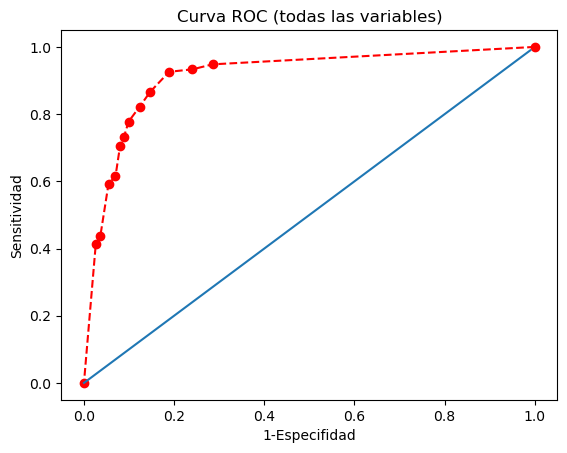

In [51]:
# plot de la curva de ROC
plt.plot(especifities_c,sensitivities, marker = 'o', linestyle = "--", color = 'r')

# pintamos la linea recta
x = [i*0.01 for i in range(100)]
y = [i*0.01 for i in range(100)]

plt.plot(x,y)
plt.xlabel('1-Especifidad')
plt.ylabel('Sensitividad')
plt.title('Curva ROC (todas las variables)')
plt.show()

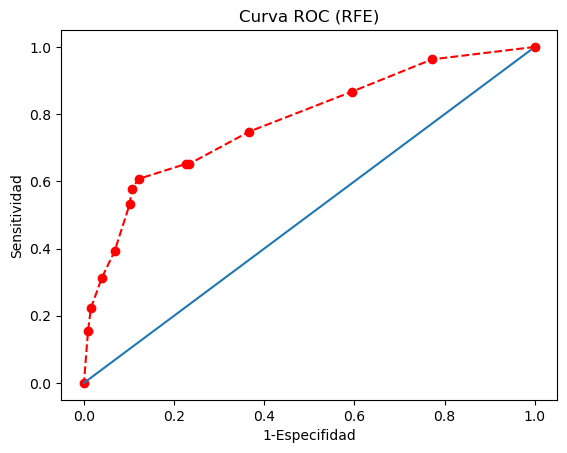

In [52]:
# Hacemos lo mismo para las 12 variables del RFE

thresholds = [0.04, 0.05, 0.07, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.3, 0.4, 0.5]

sensitivities = [1] # ya incluimos el 1, para completar el gráfico
especifities_c = [1] # 1 - especificidad

for t in thresholds:
    prob_rfe_df['prediction'] = np.where(prob_rfe_df[0] >= t, 1, 0)
    prob_rfe_df['actual'] = list(y_test) ## para que coincidadn los index
    prob_rfe_df.head()

    cm_rfe = pd.crosstab(prob_rfe_df.prediction, prob_rfe_df.actual)

    #checamos bien los indices de la matriz
    TN = cm_rfe[0][0]
    TP = cm_rfe[1][1]
    FN = cm_rfe[1][0]
    FP = cm_rfe[0][1]

    sens = TP / (TP + FN)
    sensitivities.append(sens)

    espc_c = 1 - TN/(TN + FP)
    especifities_c.append(espc_c)

# rellenamos el otro extremo, donde los valores son cero
sensitivities.append(0)
especifities_c.append(0)

# plot de la curva de ROC
plt.plot(especifities_c,sensitivities, marker = 'o', linestyle = "--", color = 'r')

# pintamos la linea recta
x = [i*0.01 for i in range(100)]
y = [i*0.01 for i in range(100)]

plt.plot(x,y)
plt.xlabel('1-Especifidad')
plt.ylabel('Sensitividad')
plt.title('Curva ROC (RFE)')
plt.show()


A medida que crece el threshold, incrementa la sensitividad y debería mucho más rápido la especifidad. Los puntos de mayor sensitividad se da con thresholds bajos. La gráfica se lee al revés.
Se pueden crear diferentes curvas ROC para cada modelo generado.

Una curva por debajo de la diagonal es un mal modelo, se equivoca mas de lo aleatorio. El área por debajo de la curva, a mayor área mejor el modelo. En el peor de los casos es cero, y en el mejor un cuadrado.

Una vez entendido el proceso de evaluación, a continuación vamos a hacer la rutina completa, pero utilizando únicamente métodos de scikit-learn, para agilizar el proceso y darle una estructura.

### Estructura del proceso con Scikit-learn

In [53]:
# 1. Instanciamos modelos, y sus hiperparámetros
lr = LogisticRegression(max_iter=20000)
lr_rfe = LogisticRegression(max_iter=20000)

# 2. Entrenamos modelos
lr.fit(X_train,y_train)
lr_rfe.fit(X_rfe_train, y_train)

# 3. Predicciones de clases y evaluación básica
y_pred = lr.predict(X_test)
y_pred_rfe = lr_rfe.predict(X_rfe_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)

print(f"Exactitud en test con todas las variables: {accuracy:.4f}")
print(f"Exactitud en test con 12 variables seleccionadas: {accuracy_rfe:.4f}")

# 4. Predicciones con probabilidades predichas
# Probabilidades para ROC y AUC
y_prob = lr.predict_proba(X_test)[:, 1]
y_prob_rfe = lr_rfe.predict_proba(X_rfe_test)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_rfe = confusion_matrix(y_test, y_pred_rfe)

# Reportes detallados (incluye precisión, recall y F1)
print("=== Reporte modelo completo ===")
print(classification_report(y_test, y_pred))

print("=== Reporte modelo con RFE ===")
print(classification_report(y_test, y_pred_rfe))

# AUC
auc = roc_auc_score(y_test, y_prob)
auc_rfe = roc_auc_score(y_test, y_prob_rfe)
print(f"AUC con todas las variables: {auc:.4f}")
print(f"AUC con RFE (12 variables): {auc_rfe:.4f}")


Exactitud en test con todas las variables: 0.9126
Exactitud en test con 12 variables seleccionadas: 0.8997
=== Reporte modelo completo ===
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1101
           1       0.66      0.41      0.51       135

    accuracy                           0.91      1236
   macro avg       0.80      0.69      0.73      1236
weighted avg       0.90      0.91      0.90      1236

=== Reporte modelo con RFE ===
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1101
           1       0.68      0.16      0.25       135

    accuracy                           0.90      1236
   macro avg       0.79      0.57      0.60      1236
weighted avg       0.88      0.90      0.87      1236

AUC con todas las variables: 0.9282
AUC con RFE (12 variables): 0.7874


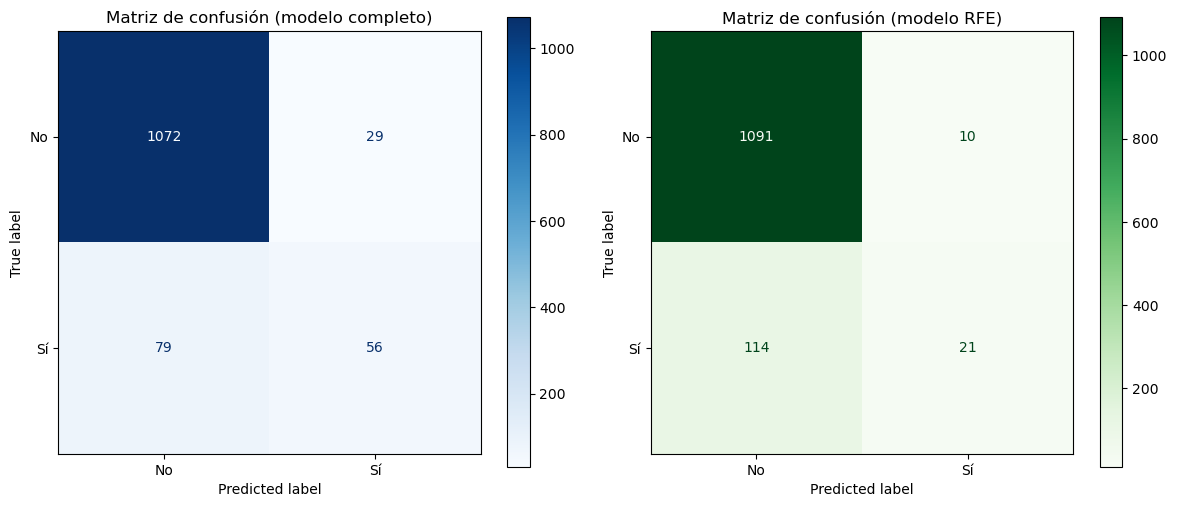

In [54]:
# Visualización de las matrices de confusión (para threshold 0.5)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm, display_labels=["No", "Sí"]).plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Matriz de confusión (modelo completo)")

ConfusionMatrixDisplay(cm_rfe, display_labels=["No", "Sí"]).plot(ax=ax[1], cmap='Greens')
ax[1].set_title("Matriz de confusión (modelo RFE)")

plt.tight_layout()
plt.show()

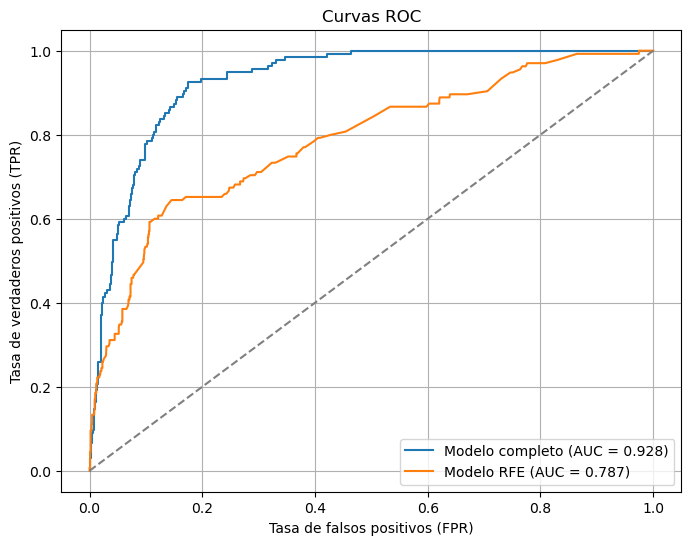

In [55]:
# Curvas de ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_rfe, tpr_rfe, _ = roc_curve(y_test, y_prob_rfe)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Modelo completo (AUC = {auc:.3f})')
plt.plot(fpr_rfe, tpr_rfe, label=f'Modelo RFE (AUC = {auc_rfe:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True)
plt.show()

## Resumen y Conclusiones

En este notebook hemos desarrollado un análisis completo de **regresión logística** aplicado al dataset de marketing bancario, con el objetivo de predecir si un cliente aceptará una oferta de depósito a plazo fijo.

### Principales hallazgos:

- **Desbalance de clases**: El dataset presenta un 89% de respuestas negativas vs 11% positivas, típico en campañas de marketing directo
- **Rendimiento del modelo**: Ambos enfoques (modelo completo y RFE) mostraron excelente performance:
  - Modelo completo: 91.26% exactitud, AUC = 0.928
  - Modelo RFE (12 variables): 89.97% exactitud, AUC = 0.787
- **Validación cruzada**: 91.16% de exactitud promedio confirma la robustez del modelo
- **Interpretabilidad**: El análisis de coeficientes permite identificar qué variables influyen más en la decisión del cliente

### Conclusiones:

El modelo de regresión logística demostró ser altamente efectivo para este problema de clasificación binaria. **El modelo con todas las variables ofrece el mejor rendimiento predictivo**, mientras que **el modelo RFE proporciona una alternativa más simple e interpretable** con solo una ligera pérdida de performance.

La implementación de diferentes umbrales de decisión y el análisis de curvas ROC permiten adaptar el modelo según las necesidades específicas del negocio, optimizando el balance entre precisión y recall según los objetivos de la campaña de marketing.

Este análisis demuestra que la regresión logística sigue siendo una herramienta poderosa y práctica para problemas de clasificación en el ámbito empresarial, especialmente cuando la interpretabilidad es crucial para la toma de decisiones.